# Load necessary Python libraries

In [0]:
pip install SimpleITK

     |████████████████████████████████| 42.5MB 71kB/s 


In [0]:
pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 3.8MB 39.8MB/s 
     |████████████████████████████████| 450kB 41.6MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found exis

In [0]:
!pip install tensorflow_addons

     |████████████████████████████████| 993kB 6.3MB/s 
     |████████████████████████████████| 421.8MB 41kB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
!nvidia-smi

Sun Jan 12 08:58:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Mount your Google Drive

In [0]:
from google.colab import drive
drive.mount('M_drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at M_drive


# Import necessary libraries to environment

In [0]:
import os
import sys
import random
import warnings

import numpy as np
import SimpleITK as itk
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from os.path import join
from PIL import Image  
import PIL  

%matplotlib notebook
%matplotlib inline

import cv2

import tensorflow as tf

from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model,load_model

from tensorflow.keras.optimizers import Adam
from os.path import join
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from keras import backend as K



#rezerviramo samo toliko spomina kot ga potrebujemo za učenje
#ce tega ne naredimo se rezervira ves spomin
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config) #v verziji 2 so določene funkcije odstranjene zato malo drugačen klic

seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


# Load validation data

In [0]:
path="M_drive/My Drive/SeminarAMS/"

X_testREAL=np.load(path+"dataset_MRI_real/dataset_split/X_test/.npy")
y_testREAL=np.load(path+"dataset_MRI_real/dataset_split/y_test/.npy")
X_testDOWN=np.load(path+"dataset_MRI_synthetic/X_test.npy")
y_testDOWN=np.load(path+"dataset_MRI_synthetic/y_test.npy")

print(y_testREAL.shape)
print(y_testDOWN.shape)

(1000, 252, 252, 3)
(400, 252, 252, 3)


# Functions for build neural network architecture

In [0]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model
#tf.compat.v1.enable_eager_execution()
MEAN = np.array([0.5, 0.5, 0.5]) * 255


def edsr(scale, num_filters=64, num_res_blocks=8, res_block_scaling=None):
    """Creates an EDSR model."""
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = upsample(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)

    x = Lambda(denormalize)(x)
    return Model(x_in, x, name="edsr")


def res_block(x_in, filters, scaling):
    """Creates an EDSR residual block."""
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x


def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        """Sub-pixel convolution."""
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(pixel_shuffle(scale=factor))(x)

    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')

    return x


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)


def normalize(x):
    return (x - MEAN) / 127.5


def denormalize(x):
    return x * 127.5 + MEAN


from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from os.path import join

import os

import matplotlib.pyplot as plt

#rezerviramo samo toliko spomina kot ga potrebujemo za učenje
#ce tega ne naredimo se rezervira ves spomin
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config) #v verziji 2 so določene funkcije odstranjene zato malo drugačen klic

# Vizualize synthetic models work

(252, 252, 3)
(252, 252, 3)


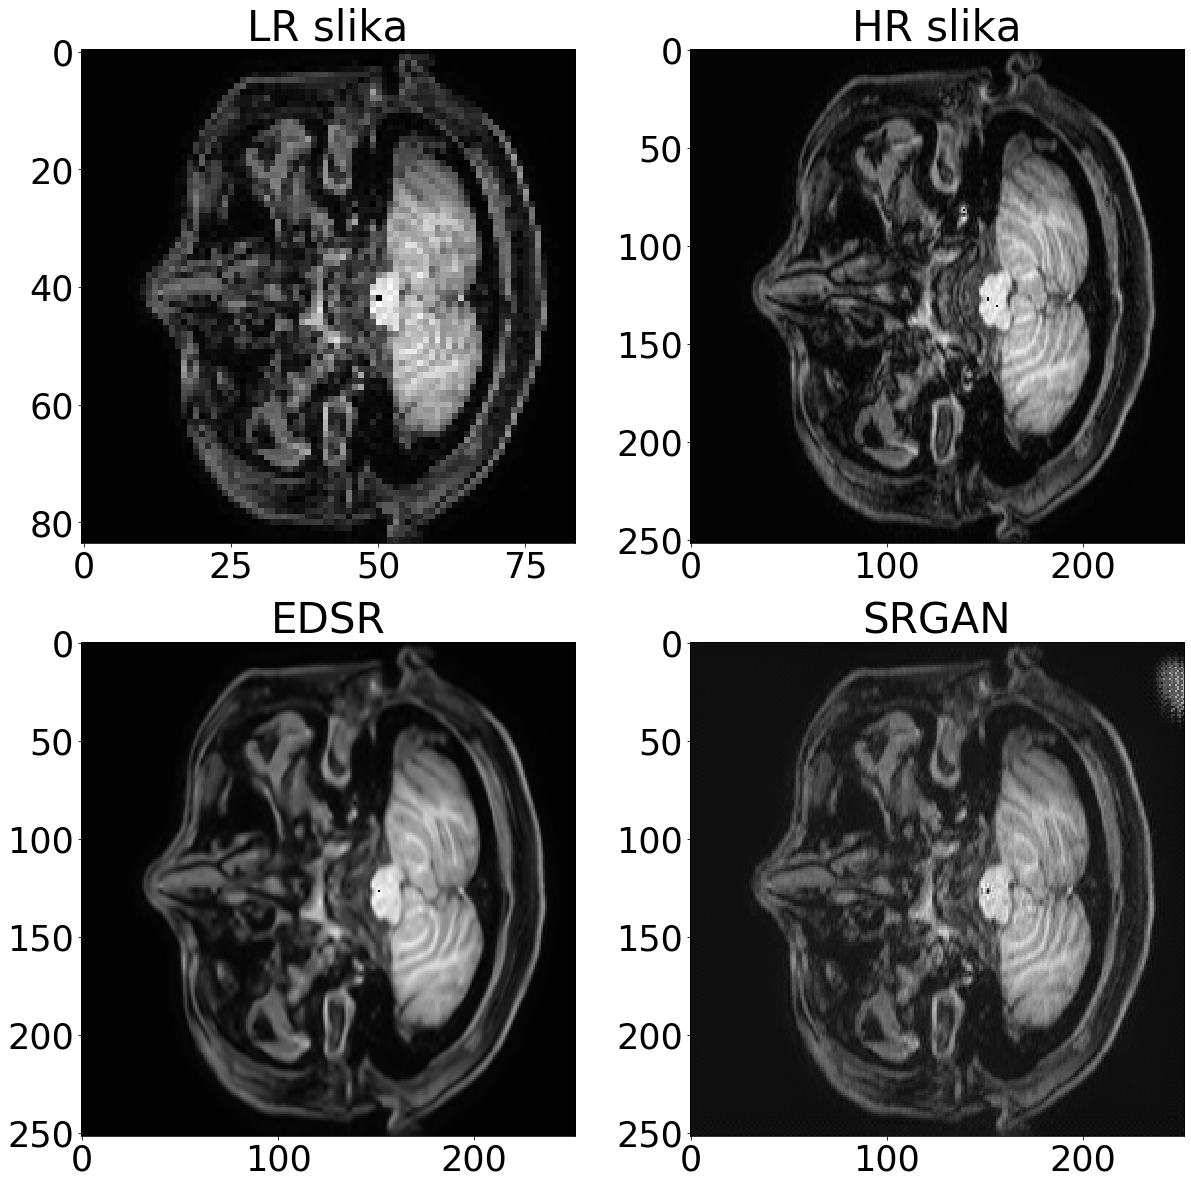

In [0]:
path="M_drive/My Drive/SeminarAMS/"
weights_dir =path+'weights_SR'
import sys
sys.path.append(path)
from PIL import Image
import scipy.misc
from model import resolve_single
edsr_pre_trained = edsr(scale=3, num_res_blocks=16)
edsr_pre_trained.load_weights(os.path.join(weights_dir, 'EDSR_300x500_LR_HR.h5'))


edsr_fine_tuned = edsr(scale=3, num_res_blocks=16)
edsr_fine_tuned.load_weights(os.path.join(weights_dir, 'EDSR_300x500_TUNED.h5'))

lr=X_testDOWN
hr=y_testDOWN
ix = random.randint(0, len(lr)-1)

sr_pt=resolve_single(edsr_pre_trained,lr[ix,:,:,:])
sr_ft = resolve_single(edsr_fine_tuned, lr[ix,:,:,:])



lr_im=(np.asarray(lr[ix,:,:,0])+np.asarray(lr[ix,:,:,1])+np.asarray(lr[ix,:,:,2]))/3
hr_im=(np.asarray(hr[ix,:,:,0])+np.asarray(hr[ix,:,:,1])+np.asarray(hr[ix,:,:,2]))/3
srpt_im=(np.asarray(sr_pt[:,:,0])+np.asarray(sr_pt[:,:,1])+np.asarray(sr_pt[:,:,2]))/3
srft_im=(np.asarray(sr_ft[:,:,0])+np.asarray(sr_ft[:,:,1])+np.asarray(sr_ft[:,:,2]))/3
print(np.asarray(hr[ix,:,:,:]).shape)
print(np.asarray(sr_pt).shape)

plt.rcParams.update({'font.size': 35})

fig=plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.imshow(lr_im,cmap="gray")
plt.title("LR slika")
plt.subplot(222)
plt.imshow(hr_im,cmap="gray")
plt.title("HR slika")
plt.subplot(223)
plt.imshow(srpt_im,cmap="gray")
plt.title("EDSR")
plt.subplot(224)
plt.imshow(srft_im,cmap="gray")
plt.title("SRGAN")

plt.savefig(path+"synthetic.png")

# Vizualize real models work

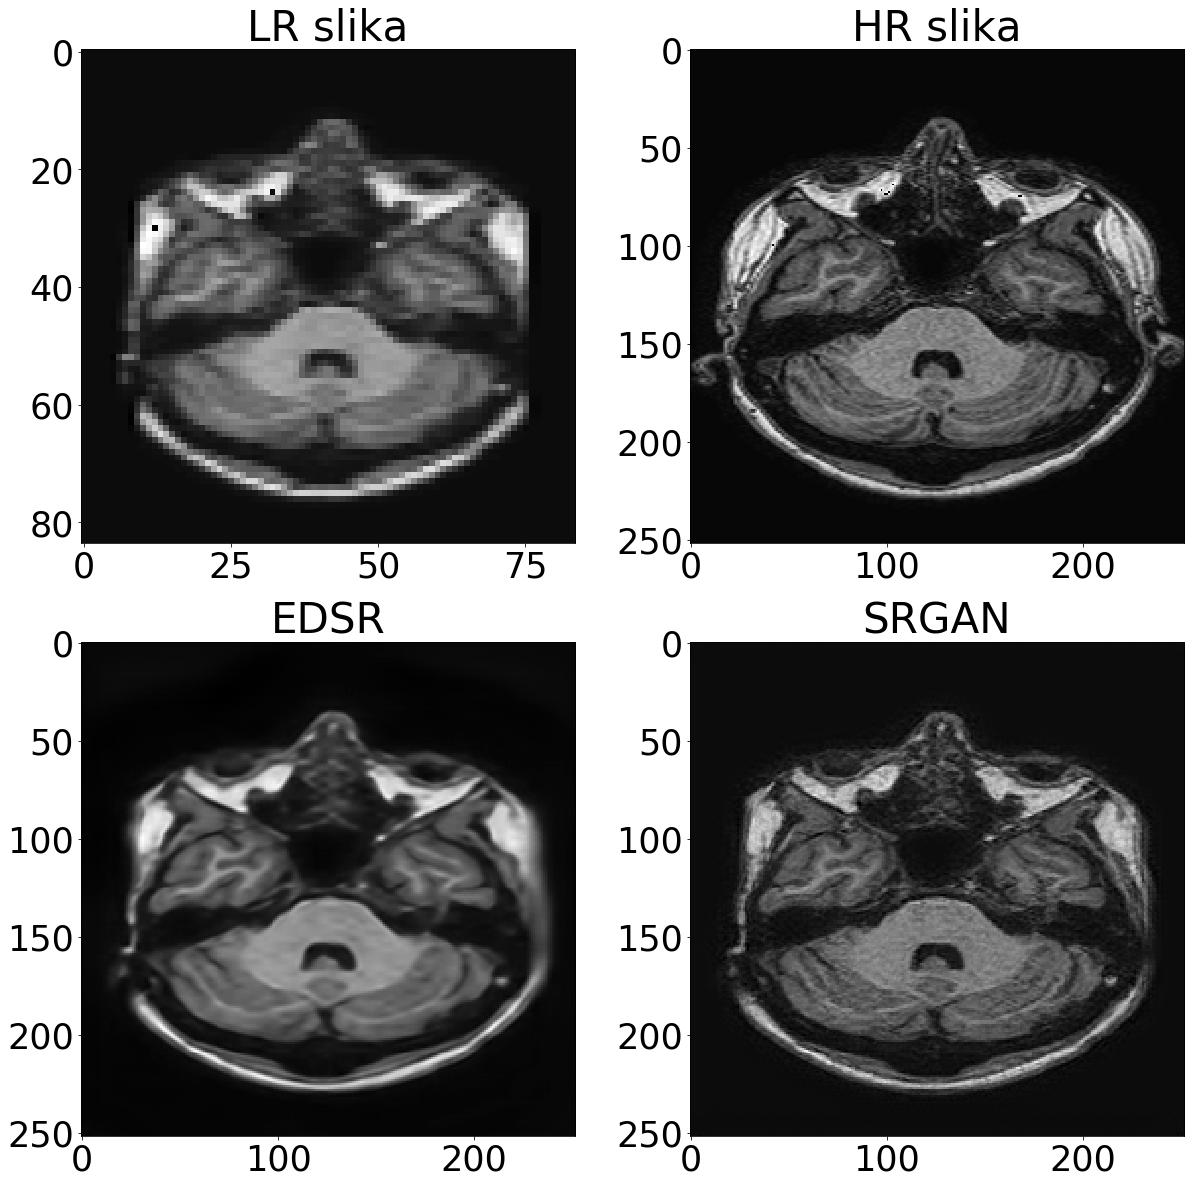

In [0]:
path="M_drive/My Drive/SeminarAMS/"
weights_dir =path+'weights_SR'
import sys
sys.path.append(path)
from PIL import Image
import scipy.misc
from model import resolve_single
edsr_pre_trained = edsr(scale=3, num_res_blocks=16)
edsr_pre_trained.load_weights(os.path.join(weights_dir, 'REAL_CROP_EDSR_300x1000.h5'))

edsr_fine_tuned = edsr(scale=3, num_res_blocks=16)
edsr_fine_tuned.load_weights(os.path.join(weights_dir, 'REAL_CROP_EDSR_300x1000_TUNED.h5'))

lr=X_testREAL
hr=y_testREAL
ix = 117

sr_pt=resolve_single(edsr_pre_trained,lr[ix,:,:,:])
sr_ft = resolve_single(edsr_fine_tuned, lr[ix,:,:,:])



lr_im=(np.asarray(lr[ix,:,:,0])+np.asarray(lr[ix,:,:,1])+np.asarray(lr[ix,:,:,2]))/3
hr_im=(np.asarray(hr[ix,:,:,0])+np.asarray(hr[ix,:,:,1])+np.asarray(hr[ix,:,:,2]))/3
srpt_im=(np.asarray(sr_pt[:,:,0])+np.asarray(sr_pt[:,:,1])+np.asarray(sr_pt[:,:,2]))/3
srft_im=(np.asarray(sr_ft[:,:,0])+np.asarray(sr_ft[:,:,1])+np.asarray(sr_ft[:,:,2]))/3



fig=plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.imshow(lr_im,cmap="gray")
plt.title("LR slika")
plt.subplot(222)
plt.imshow(hr_im,cmap="gray")
plt.title("HR slika")
plt.subplot(223)
plt.imshow(srpt_im,cmap="gray")
plt.title("EDSR")
plt.subplot(224)
plt.imshow(srft_im,cmap="gray")
plt.title("SRGAN")

plt.savefig(path+"real.png")

In [0]:
def multiply_dim(data,m,axis):
    '''
    Funkcija multiplicira željeno os v np.array

    Parameters
    ----------
    data : polje podatkov poljubne velikosti
    m : faktor množenja
    axis : številka osi ki jo želimo multiplicirati
    
    Returns
    --------
    odata : multiplicirani podatki

    '''
    
    odata=np.ndarray((data.shape[0],data.shape[1],m))
    for i in range(m):
        odata[:,:,i]=np.squeeze(data,axis=axis)
    return odata

# STATISTICS synthetic data

In [0]:
path="M_drive/My Drive/SeminarAMS/"
weights_dir =path+'weights_SR'
import sys
sys.path.append(path)
from PIL import Image
import scipy.misc
from model import resolve_single
edsr_pre_trained = edsr(scale=3, num_res_blocks=16)
edsr_pre_trained.load_weights(os.path.join(weights_dir, 'EDSR_300x500_LR_HR.h5'))


edsr_fine_tuned = edsr(scale=3, num_res_blocks=16)
edsr_fine_tuned.load_weights(os.path.join(weights_dir, 'EDSR_300x500_TUNED.h5'))

lr=X_testDOWN
hr=y_testDOWN

PSNR_EDSR=[]
SSIM_EDSR=[]

PSNR_GAN=[]
SSIM_GAN=[]
for k in range(lr.shape[0]):

  sr_pt=resolve_single(edsr_pre_trained,lr[k,:,:,:])
  sr_ft = resolve_single(edsr_fine_tuned, lr[k,:,:,:])

  hr_im=(np.asarray(hr[k,:,:,0])+np.asarray(hr[k,:,:,1])+np.asarray(hr[k,:,:,2]))/3
  srpt_im=(np.asarray(sr_pt[:,:,0])+np.asarray(sr_pt[:,:,1])+np.asarray(sr_pt[:,:,2]))/3
  srft_im=(np.asarray(sr_ft[:,:,0])+np.asarray(sr_ft[:,:,1])+np.asarray(sr_ft[:,:,2]))/3

  hr_im=hr_im[:, :, np.newaxis]
  srpt_im=srpt_im[:, :, np.newaxis]
  srft_im=srft_im[:, :, np.newaxis]

  hr_val=tf.image.convert_image_dtype(hr_im, tf.uint8)
  pt_val=tf.image.convert_image_dtype(srpt_im, tf.uint8)
  ft_val=tf.image.convert_image_dtype(srft_im, tf.uint8)

  psnr_hp=tf.image.psnr(pt_val,hr_val,max_val=255)
  psnr_hf=tf.image.psnr(ft_val,hr_val,max_val=255)

  ssim_hp=tf.image.ssim(pt_val,hr_val,max_val=255)
  ssim_hf=tf.image.ssim(ft_val,hr_val,max_val=255)

  PSNR_EDSR.append(psnr_hp.numpy())
  SSIM_EDSR.append(ssim_hp.numpy())

  PSNR_GAN.append(psnr_hf.numpy())
  SSIM_GAN.append(ssim_hf.numpy())
  if(k%10==0):
    print(k)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390


# Save PSNR and SSIM data for synthetic data

In [0]:
'''
path="M_drive/My Drive/SeminarAMS"


save_dir=path+"/validation/synthetic/PSNR_EDSR/"
os.makedirs(save_dir, exist_ok=True)
np.save(save_dir, PSNR_EDSR)

save_dir=path+"/validation/synthetic/SSIM_EDSR/"
os.makedirs(save_dir, exist_ok=True)
np.save(save_dir, SSIM_EDSR)

save_dir=path+"/validation/synthetic/PSNR_GAN/"
os.makedirs(save_dir, exist_ok=True)
np.save(save_dir, PSNR_GAN)

save_dir=path+"/validation/synthetic/SSIM_GAN/"
os.makedirs(save_dir, exist_ok=True)
np.save(save_dir, SSIM_GAN)
'''

In [0]:
path="M_drive/My Drive/SeminarAMS/"

PSNR_EDSR=np.load(path+"validation/synthetic/PSNR_EDSR/.npy")
SSIM_EDSR=np.load(path+"validation/synthetic/SSIM_EDSR/.npy")
PSNR_GAN=np.load(path+"validation/synthetic/PSNR_GAN/.npy")
SSIM_GAN=np.load(path+"validation/synthetic/SSIM_GAN/.npy")


In [0]:
print(np.mean(PSNR_EDSR))
print(np.mean(SSIM_EDSR))
print(np.std(PSNR_EDSR))
print(np.std(SSIM_EDSR))

print(np.mean(PSNR_GAN))
print(np.mean(SSIM_GAN))
print(np.std(PSNR_GAN))
print(np.std(SSIM_GAN))

13.12346
0.09898523
1.410489
0.12572928
7.075961
0.020423686
0.3818432
0.0039018218


# Represent statistic data

TypeError: ignored

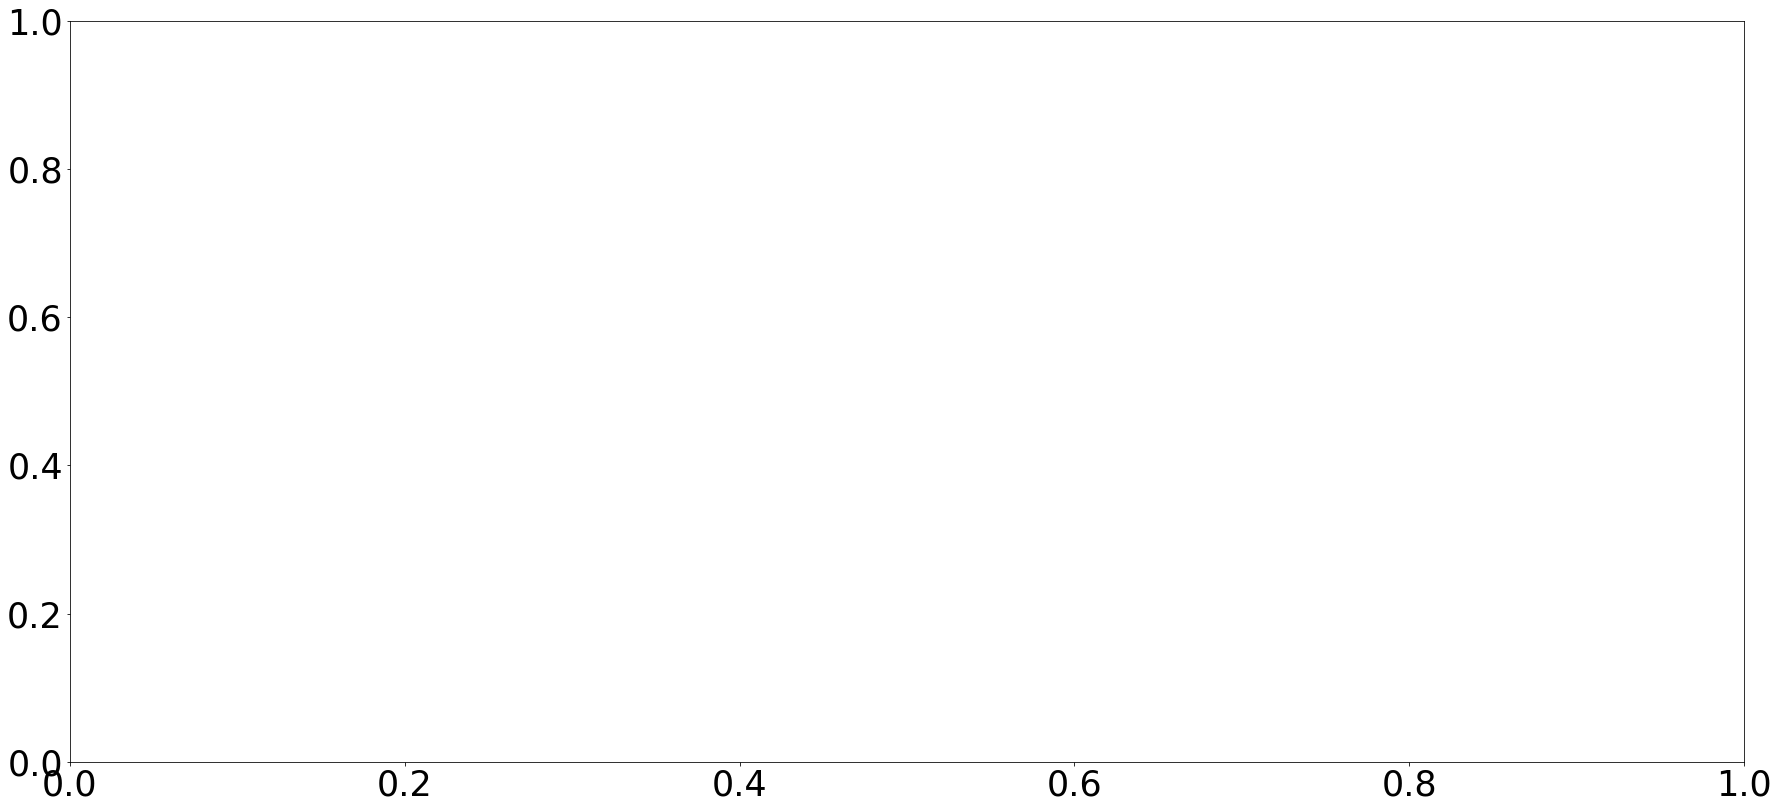

In [0]:
# Create a figure instance
fig=plt.figure(figsize=(30, 30))
METRICS_PSNR=[np.asarray(PSNR_EDSR),np.asarray(PSNR_GAN)]
METRICS_SSIM=[np.asarray(SSIM_EDSR),np.asarray(SSIM_GAN)]
# Create an axes instance
plt.subplot(211)
plt.boxplot(METRICS_PSNR,whis= [1, 99],linewidth=3)
plt.title("PSNR")
plt.subplot(212)
plt.boxplot(METRICS_SSIM,whis= [1, 99])
plt.title("SSIM")

plt.savefig(path+"syntheticBOX.png")

# STATISTICS real data

In [0]:
path="M_drive/My Drive/SeminarAMS/"
weights_dir =path+'weights_SR'
import sys
sys.path.append(path)
from PIL import Image
import scipy.misc
from model import resolve_single

edsr_CROP_300_1000 = edsr(scale=3, num_res_blocks=16)
edsr_CROP_300_1000.load_weights(os.path.join(weights_dir, 'REAL_CROP_EDSR_300x1000.h5'))


SRGAN_1000_CROP = edsr(scale=3, num_res_blocks=16)
SRGAN_1000_CROP.load_weights(os.path.join(weights_dir, 'REAL_CROP_EDSR_300x1000_TUNED.h5'))

lr=X_testREAL
hr=y_testREAL

PSNR_EDSR=[]
SSIM_EDSR=[]

PSNR_GAN=[]
SSIM_GAN=[]


for k in range(lr.shape[0]):

  sr_pt=resolve_single(edsr_CROP_300_1000,lr[k,:,:,:])
  sr_ft = resolve_single(SRGAN_1000_CROP, lr[k,:,:,:])

  hr_im=(np.asarray(hr[k,:,:,0])+np.asarray(hr[k,:,:,1])+np.asarray(hr[k,:,:,2]))/3
  srpt_im=(np.asarray(sr_pt[:,:,0])+np.asarray(sr_pt[:,:,1])+np.asarray(sr_pt[:,:,2]))/3
  srft_im=(np.asarray(sr_ft[:,:,0])+np.asarray(sr_ft[:,:,1])+np.asarray(sr_ft[:,:,2]))/3

  hr_im=hr_im[:, :, np.newaxis]
  srpt_im=srpt_im[:, :, np.newaxis]
  srft_im=srft_im[:, :, np.newaxis]

  hr_val=tf.image.convert_image_dtype(hr_im, tf.uint8)
  pt_val=tf.image.convert_image_dtype(srpt_im, tf.uint8)
  ft_val=tf.image.convert_image_dtype(srft_im, tf.uint8)

  psnr_hp=tf.image.psnr(pt_val,hr_val,max_val=255)
  psnr_hf=tf.image.psnr(ft_val,hr_val,max_val=255)

  ssim_hp=tf.image.ssim(pt_val,hr_val,max_val=255)
  ssim_hf=tf.image.ssim(ft_val,hr_val,max_val=255)

  PSNR_EDSR.append(psnr_hp.numpy())
  SSIM_EDSR.append(ssim_hp.numpy())

  PSNR_GAN.append(psnr_hf.numpy())
  SSIM_GAN.append(ssim_hf.numpy())

  if(k%10==0):
    print(k)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


# Save PSNR and SSIM data for real data

In [0]:
'''
path="M_drive/My Drive/SeminarAMS"


save_dir=path+"/validation/real/PSNR_EDSR/"
os.makedirs(save_dir, exist_ok=True)
np.save(save_dir, PSNR_EDSR)

save_dir=path+"/validation/real/SSIM_EDSR/"
os.makedirs(save_dir, exist_ok=True)
np.save(save_dir, SSIM_EDSR)

save_dir=path+"/validation/real/PSNR_GAN/"
os.makedirs(save_dir, exist_ok=True)
np.save(save_dir, PSNR_GAN)

save_dir=path+"/validation/real/SSIM_GAN/"
os.makedirs(save_dir, exist_ok=True)
np.save(save_dir, SSIM_GAN)
'''

In [0]:

path="M_drive/My Drive/SeminarAMS/"

PSNR_EDSR=np.load(path+"validation/real/PSNR_EDSR/.npy")
SSIM_EDSR=np.load(path+"validation/real/SSIM_EDSR/.npy")
PSNR_GAN=np.load(path+"validation/real/PSNR_GAN/.npy")
SSIM_GAN=np.load(path+"validation/real/SSIM_GAN/.npy")

In [0]:
#zaradi napačnih slik sem odstranil prvih in zadnjih 50 iz validacije
S_PSNR_EDSR=PSNR_EDSR
S_SSIM_EDSR=SSIM_EDSR
S_PSNR_GAN=PSNR_GAN
S_SSIM_GAN=SSIM_GAN


In [0]:
print(np.mean(S_PSNR_EDSR))
print(np.std(S_PSNR_EDSR))
print(np.mean(S_SSIM_EDSR))
print(np.std(S_SSIM_EDSR))


print(np.mean(S_PSNR_GAN))
print(np.std(S_PSNR_GAN))
print(np.mean(S_SSIM_GAN))
print(np.std(S_SSIM_GAN))

12.310287
1.5040461
0.114657626
0.1261045
10.522814
2.0289292
0.16320047
0.17470652


# Represent statistic data

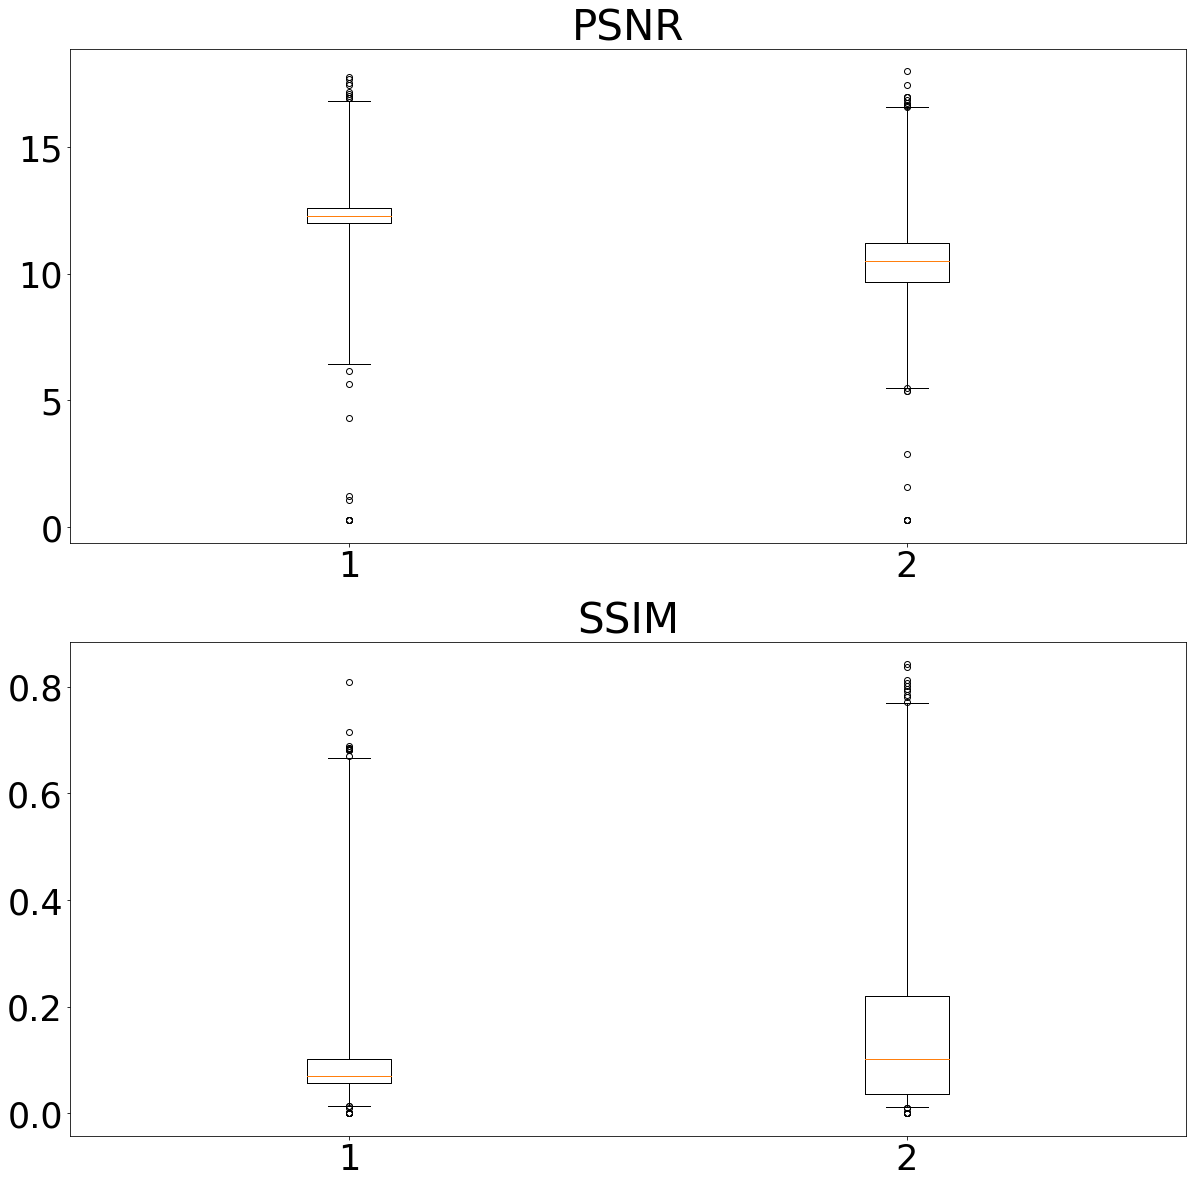

In [0]:
# Create a figure instance
plt.figure(figsize=(20, 20))
METRICS_PSNR=[np.asarray(S_PSNR_EDSR),np.asarray(S_PSNR_GAN)]
METRICS_SSIM=[np.asarray(S_SSIM_EDSR),np.asarray(S_SSIM_GAN)]

# Create an axes instance
plt.subplot(211)
plt.boxplot(METRICS_PSNR,whis= [1, 99])
plt.title("PSNR")
plt.subplot(212)
plt.boxplot(METRICS_SSIM,whis= [1, 99])
plt.title("SSIM")

plt.savefig(path+"realBOX.png")